In [9]:
import pandas as pd
import numpy as np
import csv
import tensorflow.keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler

In [3]:
inputfile = open('csv_data/traffic_flow.csv', 'r')
outputfile = open('traffic_flow1.csv', 'w')
for line in inputfile:
    line = line.replace('[', '')
    line = line.replace(']', '')
    line = line.replace("'", '')
    line = line.replace(" ", '')
    outputfile.write(line)

inputfile.close()
outputfile.close()

# csv file name
filename = "traffic_flow1.csv"

# initializing the titles and rows list
fields = []
rows = []
# reading csv file

with open(filename, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile, delimiter=',')
    # extracting field names through first row
    fields = next(csvreader)

    # extracting each data row one by one
    for row in csvreader:
        rows.append(row)

In [4]:
#convert into datafrom for easy manipulation
splitted = []
splitted.append(rows[0][0].split(',')) #header
for i in range(len(rows)):
    row = rows[i][0].split(',') 
    if len(row) == 1 or 'Street' in row:
        continue
    else:
        splitted.append(row)


df = pd.DataFrame(np.row_stack(splitted))
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header
df[['SpeedCapped','JamFactor']] = pd.to_numeric(df[['SpeedCapped','JamFactor']].stack(), errors='coerce').unstack()
df

,Street,District,Direction,FreeFlow,SpeedUncapped,SpeedCapped,JamFactor
1,B690,Radford,+,36.0,24.41,24.41,2.17025
2,B690,Bilborough,-,31.8,26.35,26.35,0.70012
3,B684,ForestFields,+,49.3,35.06,35.06,2.62651
4,B683,OldBasford,+,45.0,26.56,26.56,3.11939
5,B684,ForestFields,-,29.0,20.2,20.20,1.81868
...,...,...,...,...,...,...,...
12557,A606,WestBridgford,-,39.4,27.8,27.80,1.98363
12558,A606,WestBridgford,+,46.7,30.29,30.29,2.61032
12559,A6514,A6200DerbyRoad,-,62.5,31.66,31.66,3.14159
12560,A453,Nottingham,+,31.6,16.64,16.64,3.44030


In [5]:
one_street_data = df.loc[df['Street'] == 'B690']

In [11]:
one_street_data = df.drop(['Street', 'JamFactor', 'District', 'Direction', 'SpeedUncapped', 'FreeFlow'], axis = 1)
one_street_data

,SpeedCapped
1,24.41
2,26.35
3,35.06
4,26.56
5,20.20
...,...
12557,27.80
12558,30.29
12559,31.66
12560,16.64


In [12]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(one_street_data, 1, 50)

In [13]:
reframed

,var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),...,var1(t+40),var1(t+41),var1(t+42),var1(t+43),var1(t+44),var1(t+45),var1(t+46),var1(t+47),var1(t+48),var1(t+49)
2,24.41,26.35,35.06,26.56,20.20,27.70,23.79,22.76,7.43,35.15,...,29.31,54.49,26.23,12.50,106.85,11.97,104.04,40.44,31.97,59.13
3,26.35,35.06,26.56,20.20,27.70,23.79,22.76,7.43,35.15,30.26,...,54.49,26.23,12.50,106.85,11.97,104.04,40.44,31.97,59.13,24.72
4,35.06,26.56,20.20,27.70,23.79,22.76,7.43,35.15,30.26,27.23,...,26.23,12.50,106.85,11.97,104.04,40.44,31.97,59.13,24.72,41.24
5,26.56,20.20,27.70,23.79,22.76,7.43,35.15,30.26,27.23,23.98,...,12.50,106.85,11.97,104.04,40.44,31.97,59.13,24.72,41.24,40.70
6,20.20,27.70,23.79,22.76,7.43,35.15,30.26,27.23,23.98,21.00,...,106.85,11.97,104.04,40.44,31.97,59.13,24.72,41.24,40.70,22.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12508,26.66,37.16,15.05,20.38,31.81,29.41,4.87,28.75,21.41,14.15,...,29.12,55.77,29.77,47.48,26.86,17.46,96.41,24.91,109.83,27.80
12509,37.16,15.05,20.38,31.81,29.41,4.87,28.75,21.41,14.15,4.23,...,55.77,29.77,47.48,26.86,17.46,96.41,24.91,109.83,27.80,30.29
12510,15.05,20.38,31.81,29.41,4.87,28.75,21.41,14.15,4.23,29.12,...,29.77,47.48,26.86,17.46,96.41,24.91,109.83,27.80,30.29,31.66
12511,20.38,31.81,29.41,4.87,28.75,21.41,14.15,4.23,29.12,31.76,...,47.48,26.86,17.46,96.41,24.91,109.83,27.80,30.29,31.66,16.64


In [14]:
# split into train and test sets
values = reframed.values
n_train_hours = len(values)-2000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [15]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10511, 1, 50) (10511,) (2000, 1, 50) (2000,)


In [16]:
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer=Adam(learning_rate = 0.0001))
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
657/657 - 3s - loss: 35.1806 - val_loss: 29.7488
Epoch 2/50
657/657 - 1s - loss: 32.9493 - val_loss: 28.2481
Epoch 3/50
657/657 - 1s - loss: 31.8642 - val_loss: 27.2824
Epoch 4/50
657/657 - 1s - loss: 30.9181 - val_loss: 26.3599
Epoch 5/50
657/657 - 1s - loss: 29.9967 - val_loss: 25.4585
Epoch 6/50
657/657 - 1s - loss: 29.0890 - val_loss: 24.5701
Epoch 7/50
657/657 - 1s - loss: 28.1911 - val_loss: 23.6937
Epoch 8/50
657/657 - 1s - loss: 27.3039 - val_loss: 22.8328
Epoch 9/50
657/657 - 1s - loss: 26.4263 - val_loss: 21.9853
Epoch 10/50
657/657 - 1s - loss: 25.5590 - val_loss: 21.1497
Epoch 11/50
657/657 - 1s - loss: 24.6998 - val_loss: 20.3355
Epoch 12/50
657/657 - 1s - loss: 23.8500 - val_loss: 19.5446
Epoch 13/50
657/657 - 1s - loss: 23.0110 - val_loss: 18.7740
Epoch 14/50
657/657 - 1s - loss: 22.1854 - val_loss: 18.0213
Epoch 15/50
657/657 - 1s - loss: 21.3773 - val_loss: 17.2938
Epoch 16/50
657/657 - 1s - loss: 20.5944 - val_loss: 16.5974
Epoch 17/50
657/657 - 1s - loss: 

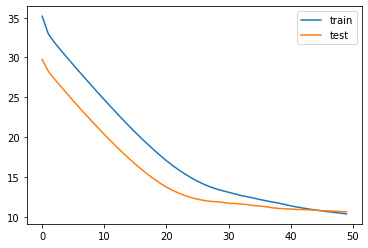

In [17]:
import matplotlib.pyplot as plt 

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [136]:
# make predictions for next timesteps
inpt = test_X[-1]
out = model.predict(np.expand_dims(inpt, 0))

for i in range(5):
    print('Speed at timestep ', i, ': ', out)
    inpt = [[inpt[0][1], inpt[0][2], out[0][0]]]
    out = model.predict(np.expand_dims(inpt, 1))


Speed at timestep  0 :  [[35.29279]]
Speed at timestep  1 :  [[33.26533]]
Speed at timestep  2 :  [[31.042444]]
Speed at timestep  3 :  [[35.861946]]
Speed at timestep  4 :  [[34.9762]]
